In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 4 Logical GPUs


2022-03-03 05:18:48.886141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 05:18:51.353973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13363 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-03-03 05:18:51.355592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14119 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2022-03-03 05:18:51.357118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [3]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [4]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [5]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [6]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [7]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [8]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [9]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [10]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [11]:
def splitDataIntoChunks3D(data, chunk_size): #chunk_size is 5
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:5])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [12]:
#set random seed 
tf.random.set_seed(42)

In [13]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [14]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

### Attempt 1: Train with all data

In [15]:
(trainX_4step, trainY_4step, trainTime_4step) = splitDataIntoChunks3D(train_data, 4)
(valX_4step, valY_4step, valTime_4step) = splitDataIntoChunks3D(val_data, 4)
(testX_4step, testY_4step, testTime_4step) = splitDataIntoChunks3D(test_data, 4)

In [16]:
#check shape of X (training)
trainX_4step_arr = np.array(trainX_4step)
trainX_4step_arr.shape

(4022, 4, 4)

In [17]:
#check shape of y (training)
trainY_4step_arr = np.array(trainY_4step)
trainY_4step_arr = trainY_4step_arr.reshape(-1, 1)
trainY_4step_arr.shape

(4022, 1)

In [18]:
#check shape of X (validation)
valX_4step_arr = np.array(valX_4step)
valX_4step_arr.shape

(635, 4, 4)

In [19]:
#check shape of y (validation)
valY_4step_arr = np.array(valY_4step)
valY_4step_arr = valY_4step_arr.reshape(-1, 1)
valY_4step_arr.shape

(635, 1)

In [20]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(4,4), return_sequences=True))
model1.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model1.add(layers.Dropout(0.5))
model1.add(layers.LSTM(32, activation='tanh'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [22]:
fileName1 = "LSTM_trainingDataTest_allData.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [23]:
learning_model1 = model1.fit(trainX_4step_arr, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500


2022-03-03 05:19:00.919252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


126/126 [==============================] - 9s 22ms/step - loss: 23.2597 - mean_squared_error: 23.2597 - val_loss: 11.6086 - val_mean_squared_error: 11.6086
Epoch 2/500
126/126 [==============================] - 2s 13ms/step - loss: 19.7157 - mean_squared_error: 19.7157 - val_loss: 11.5007 - val_mean_squared_error: 11.5007
Epoch 3/500
126/126 [==============================] - 2s 13ms/step - loss: 19.5101 - mean_squared_error: 19.5101 - val_loss: 11.5403 - val_mean_squared_error: 11.5403
Epoch 4/500
126/126 [==============================] - 2s 13ms/step - loss: 19.4151 - mean_squared_error: 19.4151 - val_loss: 11.4630 - val_mean_squared_error: 11.4630
Epoch 5/500
126/126 [==============================] - 2s 13ms/step - loss: 19.3325 - mean_squared_error: 19.3325 - val_loss: 11.4477 - val_mean_squared_error: 11.4477
Epoch 6/500
126/126 [==============================] - 2s 13ms/step - loss: 19.3901 - mean_squared_error: 19.3901 - val_loss: 11.4465 - val_mean_squared_error: 11.4465
Epoc

Epoch 50/500
126/126 [==============================] - 2s 13ms/step - loss: 16.9096 - mean_squared_error: 16.9096 - val_loss: 9.4524 - val_mean_squared_error: 9.4524
Epoch 51/500
126/126 [==============================] - 2s 13ms/step - loss: 16.9372 - mean_squared_error: 16.9372 - val_loss: 9.5207 - val_mean_squared_error: 9.5207
Epoch 52/500
126/126 [==============================] - 2s 13ms/step - loss: 16.9761 - mean_squared_error: 16.9761 - val_loss: 9.5527 - val_mean_squared_error: 9.5527
Epoch 53/500
126/126 [==============================] - 2s 13ms/step - loss: 16.8951 - mean_squared_error: 16.8951 - val_loss: 9.4834 - val_mean_squared_error: 9.4834
Epoch 54/500
126/126 [==============================] - 2s 13ms/step - loss: 16.8671 - mean_squared_error: 16.8671 - val_loss: 9.3955 - val_mean_squared_error: 9.3955
Epoch 55/500
126/126 [==============================] - 2s 12ms/step - loss: 16.9214 - mean_squared_error: 16.9214 - val_loss: 9.5491 - val_mean_squared_error: 9.549

126/126 [==============================] - 2s 12ms/step - loss: 16.7391 - mean_squared_error: 16.7391 - val_loss: 9.2611 - val_mean_squared_error: 9.2611
Epoch 100/500
126/126 [==============================] - 2s 13ms/step - loss: 16.7386 - mean_squared_error: 16.7386 - val_loss: 9.1936 - val_mean_squared_error: 9.1936
Epoch 101/500
126/126 [==============================] - 2s 13ms/step - loss: 16.7162 - mean_squared_error: 16.7162 - val_loss: 9.1834 - val_mean_squared_error: 9.1834
Epoch 102/500
126/126 [==============================] - 2s 12ms/step - loss: 16.6656 - mean_squared_error: 16.6656 - val_loss: 9.2246 - val_mean_squared_error: 9.2246
Epoch 103/500
126/126 [==============================] - 2s 13ms/step - loss: 16.7136 - mean_squared_error: 16.7136 - val_loss: 9.2170 - val_mean_squared_error: 9.2170
Epoch 104/500
126/126 [==============================] - 2s 13ms/step - loss: 16.7118 - mean_squared_error: 16.7118 - val_loss: 9.1370 - val_mean_squared_error: 9.1370
Epoch 

Epoch 148/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5158 - mean_squared_error: 16.5158 - val_loss: 9.1594 - val_mean_squared_error: 9.1594
Epoch 149/500
126/126 [==============================] - 2s 13ms/step - loss: 16.4719 - mean_squared_error: 16.4719 - val_loss: 9.0959 - val_mean_squared_error: 9.0959
Epoch 150/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5280 - mean_squared_error: 16.5280 - val_loss: 8.9806 - val_mean_squared_error: 8.9806
Epoch 151/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5654 - mean_squared_error: 16.5654 - val_loss: 9.0829 - val_mean_squared_error: 9.0829
Epoch 152/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5138 - mean_squared_error: 16.5138 - val_loss: 9.1138 - val_mean_squared_error: 9.1138
Epoch 153/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5569 - mean_squared_error: 16.5569 - val_loss: 9.1736 - val_mean_squared_error:

Epoch 197/500
126/126 [==============================] - 2s 13ms/step - loss: 16.2636 - mean_squared_error: 16.2636 - val_loss: 9.3543 - val_mean_squared_error: 9.3543
Epoch 198/500
126/126 [==============================] - 2s 13ms/step - loss: 16.1605 - mean_squared_error: 16.1605 - val_loss: 9.4166 - val_mean_squared_error: 9.4166
Epoch 199/500
126/126 [==============================] - 2s 13ms/step - loss: 16.2058 - mean_squared_error: 16.2058 - val_loss: 9.4441 - val_mean_squared_error: 9.4441
Epoch 200/500
126/126 [==============================] - 2s 13ms/step - loss: 16.2074 - mean_squared_error: 16.2074 - val_loss: 9.3483 - val_mean_squared_error: 9.3483
Epoch 201/500
126/126 [==============================] - 2s 13ms/step - loss: 16.1033 - mean_squared_error: 16.1033 - val_loss: 9.4715 - val_mean_squared_error: 9.4715
Epoch 202/500
126/126 [==============================] - 2s 13ms/step - loss: 16.1382 - mean_squared_error: 16.1382 - val_loss: 9.4347 - val_mean_squared_error:

Epoch 246/500
126/126 [==============================] - 2s 13ms/step - loss: 15.8688 - mean_squared_error: 15.8688 - val_loss: 9.6078 - val_mean_squared_error: 9.6078
Epoch 247/500
126/126 [==============================] - 2s 13ms/step - loss: 15.8556 - mean_squared_error: 15.8556 - val_loss: 9.5788 - val_mean_squared_error: 9.5788
Epoch 248/500
126/126 [==============================] - 2s 12ms/step - loss: 15.7154 - mean_squared_error: 15.7154 - val_loss: 9.5503 - val_mean_squared_error: 9.5503
Epoch 249/500
126/126 [==============================] - 2s 13ms/step - loss: 15.9316 - mean_squared_error: 15.9316 - val_loss: 9.4629 - val_mean_squared_error: 9.4629
Epoch 250/500
126/126 [==============================] - 2s 13ms/step - loss: 15.8387 - mean_squared_error: 15.8387 - val_loss: 9.5958 - val_mean_squared_error: 9.5958
Epoch 251/500
126/126 [==============================] - 2s 13ms/step - loss: 15.9643 - mean_squared_error: 15.9643 - val_loss: 9.6072 - val_mean_squared_error:

Epoch 295/500
126/126 [==============================] - 2s 13ms/step - loss: 16.5994 - mean_squared_error: 16.5994 - val_loss: 9.3258 - val_mean_squared_error: 9.3258
Epoch 296/500
126/126 [==============================] - 2s 13ms/step - loss: 16.0795 - mean_squared_error: 16.0795 - val_loss: 9.5476 - val_mean_squared_error: 9.5476
Epoch 297/500
126/126 [==============================] - 2s 13ms/step - loss: 15.8440 - mean_squared_error: 15.8440 - val_loss: 9.6428 - val_mean_squared_error: 9.6428
Epoch 298/500
126/126 [==============================] - 2s 13ms/step - loss: 15.5916 - mean_squared_error: 15.5916 - val_loss: 9.5667 - val_mean_squared_error: 9.5667
Epoch 299/500
126/126 [==============================] - 2s 13ms/step - loss: 15.6706 - mean_squared_error: 15.6706 - val_loss: 9.5970 - val_mean_squared_error: 9.5970
Epoch 300/500
126/126 [==============================] - 2s 13ms/step - loss: 15.5433 - mean_squared_error: 15.5433 - val_loss: 9.7316 - val_mean_squared_error:

Epoch 344/500
126/126 [==============================] - 2s 13ms/step - loss: 15.4022 - mean_squared_error: 15.4022 - val_loss: 9.9187 - val_mean_squared_error: 9.9187
Epoch 345/500
126/126 [==============================] - 2s 13ms/step - loss: 15.1929 - mean_squared_error: 15.1929 - val_loss: 9.9754 - val_mean_squared_error: 9.9754
Epoch 346/500
126/126 [==============================] - 2s 13ms/step - loss: 15.0554 - mean_squared_error: 15.0554 - val_loss: 10.0301 - val_mean_squared_error: 10.0301
Epoch 347/500
126/126 [==============================] - 2s 13ms/step - loss: 15.2105 - mean_squared_error: 15.2105 - val_loss: 9.9289 - val_mean_squared_error: 9.9289
Epoch 348/500
126/126 [==============================] - 2s 13ms/step - loss: 15.2222 - mean_squared_error: 15.2222 - val_loss: 10.0347 - val_mean_squared_error: 10.0347
Epoch 349/500
126/126 [==============================] - 2s 12ms/step - loss: 15.2044 - mean_squared_error: 15.2044 - val_loss: 10.2803 - val_mean_squared_e

126/126 [==============================] - 2s 13ms/step - loss: 14.5488 - mean_squared_error: 14.5488 - val_loss: 11.0297 - val_mean_squared_error: 11.0297
Epoch 441/500
126/126 [==============================] - 2s 13ms/step - loss: 14.4001 - mean_squared_error: 14.4001 - val_loss: 10.9347 - val_mean_squared_error: 10.9347
Epoch 442/500
126/126 [==============================] - 2s 13ms/step - loss: 14.1875 - mean_squared_error: 14.1875 - val_loss: 10.9963 - val_mean_squared_error: 10.9963
Epoch 443/500
126/126 [==============================] - 2s 13ms/step - loss: 14.0790 - mean_squared_error: 14.0790 - val_loss: 10.7509 - val_mean_squared_error: 10.7509
Epoch 444/500
126/126 [==============================] - 2s 13ms/step - loss: 14.1993 - mean_squared_error: 14.1993 - val_loss: 11.0604 - val_mean_squared_error: 11.0604
Epoch 445/500
126/126 [==============================] - 2s 13ms/step - loss: 14.1687 - mean_squared_error: 14.1687 - val_loss: 10.5725 - val_mean_squared_error: 10

In [24]:
model1 = tf.keras.models.load_model('LSTM_trainingDataTest_allData.h5')

Results of the Investigate Timesteps notebook is used. 

In [25]:
#performance on training set
trainPredict1 = model1.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_4step_arr, trainPredict1)
trainSscore1 = findSscore(trainY_4step_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.0557 RMSE 0.1190 R2 Score 5354.3833 S score


In [26]:
#performance on validation set
valPredict1 = model1.predict(valX_4step_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict1))
valR2Score1 = r2_score(valY_4step_arr, valPredict1)
valSscore1 = findSscore(valY_4step_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 2.9968 RMSE 0.2160 R2 Score 800.5998 S score


In [27]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [28]:
allRUL = all_df['RUL']
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_4step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


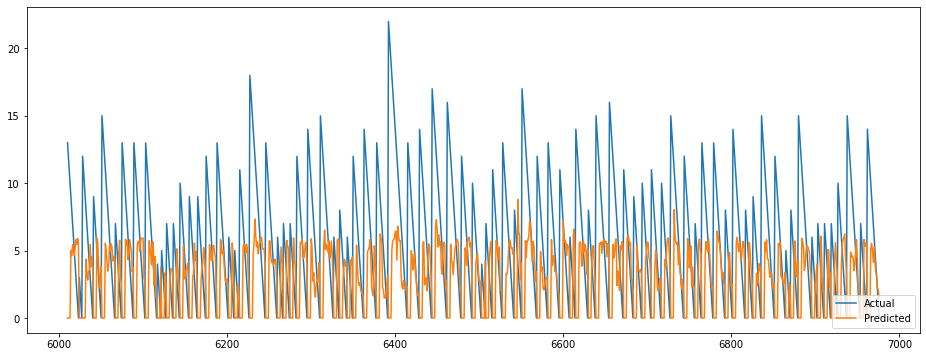

In [29]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal1)
plt.plot(timeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

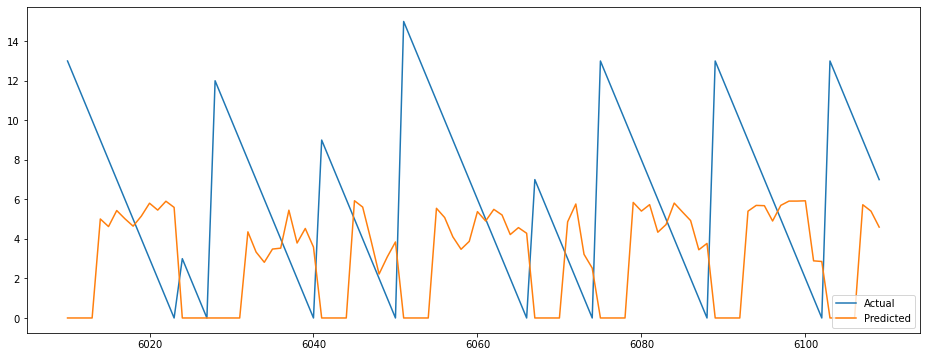

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal1[0:100])
plt.plot(timeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 2: Train with degradation data only

In [31]:
(trainX_4step_cleaned, trainY_4step_cleaned, trainTime_4step_cleaned) = splitDataIntoChunks3D(train_data_cleaned, 4)

In [32]:
#check shape of X (training)
trainX_4step_cleaned_arr = np.array(trainX_4step_cleaned)
trainX_4step_cleaned_arr.shape

(3654, 4, 4)

In [33]:
#check shape of y (training)
trainY_4step_cleaned_arr = np.array(trainY_4step_cleaned)
trainY_4step_cleaned_arr = trainY_4step_cleaned_arr.reshape(-1, 1)
trainY_4step_cleaned_arr.shape

(3654, 1)

In [34]:
#configure architecture 
model2 = models.Sequential()
model2.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(4,4), return_sequences=True))
model2.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model2.add(layers.Dropout(0.5))
model2.add(layers.LSTM(32, activation='tanh'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [35]:
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [36]:
fileName2 = "LSTM_trainingDataTest_degradationDataOnly.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [37]:
learning_model2 = model2.fit(trainX_4step_cleaned_arr, trainY_4step_cleaned_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
115/115 [==============================] - 7s 22ms/step - loss: 22.7458 - mean_squared_error: 22.7458 - val_loss: 11.5333 - val_mean_squared_error: 11.5333
Epoch 2/500
115/115 [==============================] - 1s 12ms/step - loss: 19.1214 - mean_squared_error: 19.1214 - val_loss: 11.5749 - val_mean_squared_error: 11.5749
Epoch 3/500
115/115 [==============================] - 1s 13ms/step - loss: 18.8105 - mean_squared_error: 18.8105 - val_loss: 11.5370 - val_mean_squared_error: 11.5370
Epoch 4/500
115/115 [==============================] - 1s 13ms/step - loss: 18.8597 - mean_squared_error: 18.8597 - val_loss: 11.5158 - val_mean_squared_error: 11.5158
Epoch 5/500
115/115 [==============================] - 1s 13ms/step - loss: 18.7582 - mean_squared_error: 18.7582 - val_loss: 11.4698 - val_mean_squared_error: 11.4698
Epoch 6/500
115/115 [==============================] - 2s 13ms/step - loss: 18.7484 - mean_squared_error: 18.7484 - val_loss: 11.4545 - val_mean_squared_error: 

Epoch 50/500
115/115 [==============================] - 1s 13ms/step - loss: 16.2081 - mean_squared_error: 16.2081 - val_loss: 9.2971 - val_mean_squared_error: 9.2971
Epoch 51/500
115/115 [==============================] - 2s 14ms/step - loss: 16.2006 - mean_squared_error: 16.2006 - val_loss: 9.2589 - val_mean_squared_error: 9.2589
Epoch 52/500
115/115 [==============================] - 1s 12ms/step - loss: 16.2826 - mean_squared_error: 16.2826 - val_loss: 9.2960 - val_mean_squared_error: 9.2960
Epoch 53/500
115/115 [==============================] - 1s 13ms/step - loss: 16.1751 - mean_squared_error: 16.1751 - val_loss: 9.3702 - val_mean_squared_error: 9.3702
Epoch 54/500
115/115 [==============================] - 1s 13ms/step - loss: 16.2217 - mean_squared_error: 16.2217 - val_loss: 9.3047 - val_mean_squared_error: 9.3047
Epoch 55/500
115/115 [==============================] - 1s 13ms/step - loss: 16.3143 - mean_squared_error: 16.3143 - val_loss: 9.2858 - val_mean_squared_error: 9.285

115/115 [==============================] - 1s 13ms/step - loss: 15.9793 - mean_squared_error: 15.9793 - val_loss: 9.3844 - val_mean_squared_error: 9.3844
Epoch 100/500
115/115 [==============================] - 1s 12ms/step - loss: 16.0079 - mean_squared_error: 16.0079 - val_loss: 9.3301 - val_mean_squared_error: 9.3301
Epoch 101/500
115/115 [==============================] - 1s 13ms/step - loss: 16.0038 - mean_squared_error: 16.0038 - val_loss: 9.2791 - val_mean_squared_error: 9.2791
Epoch 102/500
115/115 [==============================] - 1s 13ms/step - loss: 15.9425 - mean_squared_error: 15.9425 - val_loss: 9.3795 - val_mean_squared_error: 9.3795
Epoch 103/500
115/115 [==============================] - 1s 13ms/step - loss: 16.0569 - mean_squared_error: 16.0569 - val_loss: 9.3676 - val_mean_squared_error: 9.3676
Epoch 104/500
115/115 [==============================] - 1s 13ms/step - loss: 15.9634 - mean_squared_error: 15.9634 - val_loss: 9.3295 - val_mean_squared_error: 9.3295
Epoch 

Epoch 148/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7688 - mean_squared_error: 15.7688 - val_loss: 9.2600 - val_mean_squared_error: 9.2600
Epoch 149/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7324 - mean_squared_error: 15.7324 - val_loss: 9.3782 - val_mean_squared_error: 9.3782
Epoch 150/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7926 - mean_squared_error: 15.7926 - val_loss: 9.6541 - val_mean_squared_error: 9.6541
Epoch 151/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7328 - mean_squared_error: 15.7328 - val_loss: 9.4241 - val_mean_squared_error: 9.4241
Epoch 152/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7587 - mean_squared_error: 15.7587 - val_loss: 9.3568 - val_mean_squared_error: 9.3568
Epoch 153/500
115/115 [==============================] - 1s 13ms/step - loss: 15.7268 - mean_squared_error: 15.7268 - val_loss: 9.3606 - val_mean_squared_error:

Epoch 197/500
115/115 [==============================] - 1s 13ms/step - loss: 15.5344 - mean_squared_error: 15.5344 - val_loss: 9.2743 - val_mean_squared_error: 9.2743
Epoch 198/500
115/115 [==============================] - 1s 13ms/step - loss: 15.4788 - mean_squared_error: 15.4788 - val_loss: 9.3042 - val_mean_squared_error: 9.3042
Epoch 199/500
115/115 [==============================] - 1s 13ms/step - loss: 15.4126 - mean_squared_error: 15.4126 - val_loss: 9.3598 - val_mean_squared_error: 9.3598
Epoch 200/500
115/115 [==============================] - 1s 13ms/step - loss: 15.4247 - mean_squared_error: 15.4247 - val_loss: 9.3010 - val_mean_squared_error: 9.3010
Epoch 201/500
115/115 [==============================] - 1s 13ms/step - loss: 15.4670 - mean_squared_error: 15.4670 - val_loss: 9.6451 - val_mean_squared_error: 9.6451
Epoch 202/500
115/115 [==============================] - 1s 13ms/step - loss: 15.5042 - mean_squared_error: 15.5042 - val_loss: 9.4498 - val_mean_squared_error:

Epoch 246/500
115/115 [==============================] - 1s 12ms/step - loss: 15.0517 - mean_squared_error: 15.0517 - val_loss: 9.6784 - val_mean_squared_error: 9.6784
Epoch 247/500
115/115 [==============================] - 1s 12ms/step - loss: 14.9817 - mean_squared_error: 14.9817 - val_loss: 9.8075 - val_mean_squared_error: 9.8075
Epoch 248/500
115/115 [==============================] - 1s 13ms/step - loss: 15.0130 - mean_squared_error: 15.0130 - val_loss: 9.7499 - val_mean_squared_error: 9.7499
Epoch 249/500
115/115 [==============================] - 1s 12ms/step - loss: 14.9391 - mean_squared_error: 14.9391 - val_loss: 9.6620 - val_mean_squared_error: 9.6620
Epoch 250/500
115/115 [==============================] - 1s 13ms/step - loss: 15.0394 - mean_squared_error: 15.0394 - val_loss: 9.4933 - val_mean_squared_error: 9.4933
Epoch 251/500
115/115 [==============================] - 1s 13ms/step - loss: 14.9950 - mean_squared_error: 14.9950 - val_loss: 9.4705 - val_mean_squared_error:

115/115 [==============================] - 1s 13ms/step - loss: 14.2963 - mean_squared_error: 14.2963 - val_loss: 10.6307 - val_mean_squared_error: 10.6307
Epoch 343/500
115/115 [==============================] - 1s 13ms/step - loss: 13.8477 - mean_squared_error: 13.8477 - val_loss: 10.4498 - val_mean_squared_error: 10.4498
Epoch 344/500
115/115 [==============================] - 1s 12ms/step - loss: 13.9788 - mean_squared_error: 13.9788 - val_loss: 10.8062 - val_mean_squared_error: 10.8062
Epoch 345/500
115/115 [==============================] - 1s 13ms/step - loss: 14.0428 - mean_squared_error: 14.0428 - val_loss: 10.5645 - val_mean_squared_error: 10.5645
Epoch 346/500
115/115 [==============================] - 1s 13ms/step - loss: 14.2613 - mean_squared_error: 14.2613 - val_loss: 10.6928 - val_mean_squared_error: 10.6928
Epoch 347/500
115/115 [==============================] - 1s 13ms/step - loss: 13.9050 - mean_squared_error: 13.9050 - val_loss: 10.5635 - val_mean_squared_error: 10

115/115 [==============================] - 1s 12ms/step - loss: 12.6899 - mean_squared_error: 12.6899 - val_loss: 11.5274 - val_mean_squared_error: 11.5274
Epoch 439/500
115/115 [==============================] - 1s 12ms/step - loss: 12.8328 - mean_squared_error: 12.8328 - val_loss: 11.6660 - val_mean_squared_error: 11.6660
Epoch 440/500
115/115 [==============================] - 1s 13ms/step - loss: 12.7198 - mean_squared_error: 12.7198 - val_loss: 11.3770 - val_mean_squared_error: 11.3770
Epoch 441/500
115/115 [==============================] - 1s 13ms/step - loss: 12.9072 - mean_squared_error: 12.9072 - val_loss: 11.5370 - val_mean_squared_error: 11.5370
Epoch 442/500
115/115 [==============================] - 1s 13ms/step - loss: 12.6857 - mean_squared_error: 12.6857 - val_loss: 11.6216 - val_mean_squared_error: 11.6216
Epoch 443/500
115/115 [==============================] - 1s 13ms/step - loss: 12.5234 - mean_squared_error: 12.5234 - val_loss: 11.5399 - val_mean_squared_error: 11

In [38]:
model2 = tf.keras.models.load_model('LSTM_trainingDataTest_degradationDataOnly.h5')

In [39]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.0598 RMSE 0.1172 R2 Score 5396.1473 S score


In [40]:
#performance on validation set
valPredict2 = model2.predict(valX_4step_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_arr, valPredict2)
valSscore2 = findSscore(valY_4step_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 3.0381 RMSE 0.1943 R2 Score 807.0389 S score


In [41]:
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


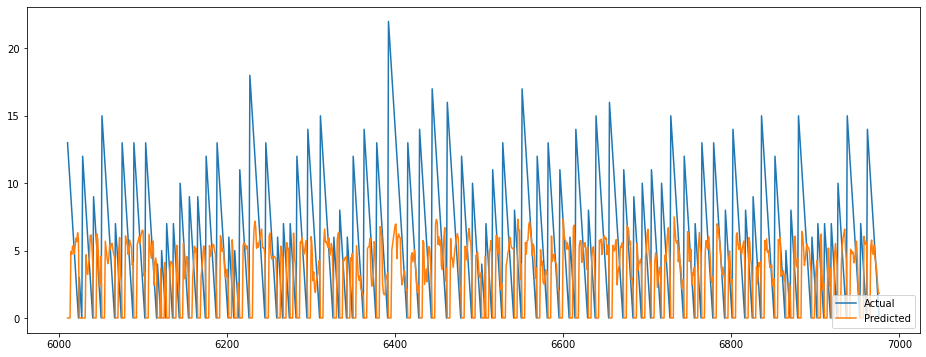

In [42]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal2)
plt.plot(timeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

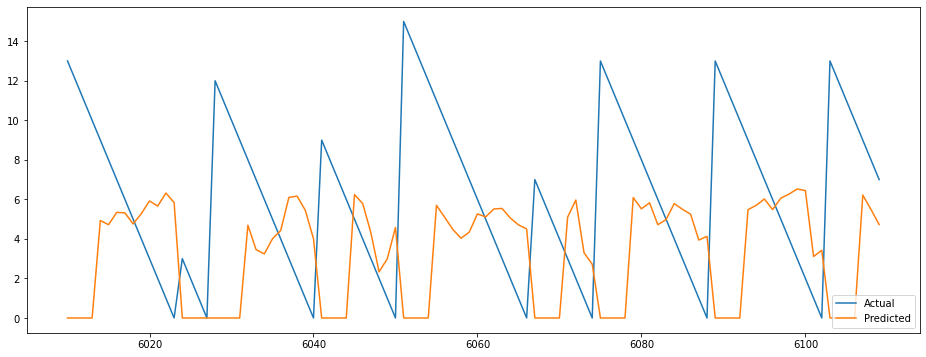

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal2[0:100])
plt.plot(timeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()